In [1]:
# file: py_c2bec2d/gpe_xmds.py

import shlex, subprocess
import numpy as np

import h5py

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt 
plt.style.use(['tableau-colorblind10'])

In [3]:
# file: py_c2bec2d/gpe_xmds.py

def run_shell_command(cmdline, output=True):
    print("run shell command: ", cmdline, "\n")
    args = shlex.split(cmdline)
    # let's use the new run command
    p = subprocess.run(args, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    if output:
        print(p.stdout.decode('utf-8'))
        return p.stderr    

In [4]:
run_shell_command('ls', output=False)

run shell command:  ls 



# GP Solution with xmds2

## Generate xmds file with desired number of lattice points, ranges in $x$ and $y$ coordinates, maximum simulation time etc.

In [5]:
# file: py_c2bec2d/gpe_xmds.py

def generate_xmdsfile(xmax=10.0, ymax=10, nlat=128, tmax=1, xmdstol=1.e-8,
                      nsamples1=4, nsamples2=4, args_in_filename="no",
                      xmds_compile="compile_gpe.xmds",
                      xmdstemplate="template_gpe.xmds"):

    # Read in the template file
    with open(xmdstemplate, 'r') as file :
      filedata = file.read()
    
    # Replace the target strings
    filedata = filedata.replace('xmaxVALUE',   str(xmax))
    filedata = filedata.replace('ymaxVALUE',   str(ymax))
    filedata = filedata.replace('nlatVALUE',   str(nlat))
    filedata = filedata.replace('nsamples1VALUE',   str(nsamples1))
    filedata = filedata.replace('nsamples2VALUE',   str(nsamples2))
    filedata = filedata.replace('tmaxVALUE',   str(tmax))
    filedata = filedata.replace('tolVALUE',    str(xmdstol))
    filedata = filedata.replace('argsVALUE',   args_in_filename)

    # Write out the file to be compiledb
    with open(xmds_compile, 'w') as file:
      file.write(filedata)
    
    print("xmds file to compile: "+xmds_compile)

In [6]:
# Simulation parameters
xmax=10
ymax=xmax
nlat=128

In [7]:
generate_xmdsfile(tmax=1, nlat=nlat)

xmds file to compile: compile_gpe.xmds


In [8]:
# file: py_c2bec2d/gpe_xmds.py

def compile_xmds(xmds_compile="compile_gpe.xmds", output=True):
    cmdline  = 'xmds2 '+xmds_compile
    return run_shell_command(cmdline,output=output)

In [9]:
stderr = compile_xmds(output=True)

run shell command:  xmds2 compile_gpe.xmds 

xmds2 version 3.0.0 "Release the Kraken" (r3071)
Copyright 2000-2019 Graham Dennis, Joseph Hope, Mattias Johnsson
                    and the xmds team
Generating source code...
... done
Compiling simulation...
... done. Type './xgpe2d' to run.



## create and save initial wave function 

In [10]:
# file: py_c2bec2d/gpe_xmds.py

def save_real_func_as_h5(xa, ya, sa, Vext, variable_name="Vext0", file_name="func.h5"):
    import h5py
    hf = h5py.File(file_name, "w")
    hf.create_dataset("x", data=xa)
    hf.create_dataset("y", data=ya)
    hf.create_dataset("s", data=sa)
    hf.create_dataset(variable_name, data=Vext)
    hf.close()
    print("saved file "+file_name)

def save_complex_func_as_h5(xa, ya, sa, phi0, variable_name="phi0", file_name="cfunc.h5"):
    import h5py
    hf = h5py.File(file_name, "w")
    hf.create_dataset("x", data=xa)
    hf.create_dataset("y", data=ya)
    hf.create_dataset("s", data=sa)
    hf.create_dataset(variable_name+"R", data=phi0.real)
    hf.create_dataset(variable_name+"I", data=phi0.imag)
    hf.close()
    print("saved file "+file_name)

In [11]:
xa = np.linspace(-xmax,xmax,nlat+1)[:-1]
ya = np.linspace(-ymax,ymax,nlat+1)[:-1]
sa = np.array([1, 2])


xx, yy, ss= np.meshgrid(xa,ya,sa,indexing='xy')  ### changed the index by 'xy' from 'ij'

r2 = xx**2 + yy**2 
σ2 = ss

phi0 = np.exp(-r2/(2*σ2))+0*1j
norm2 = np.sum(np.abs(phi0)**2,axis=(0,1))*(xa[1]-xa[0])*(ya[1]-ya[0])
#print(norm2)
phi0[:,:,0] = phi0[:,:,0]/np.sqrt(norm2[0])
phi0[:,:,1] = phi0[:,:,1]/np.sqrt(norm2[1])

saved file 2phi0.h5


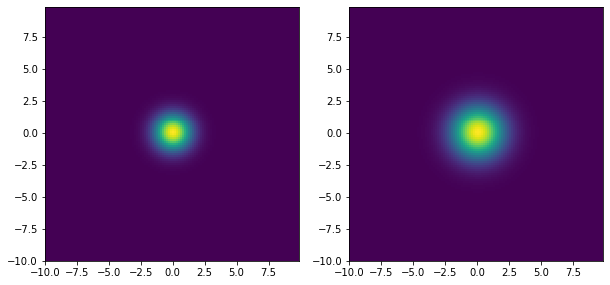

In [12]:
fig, ax = plt.subplots(1,2,figsize=(10,5))

for i in range(2):
    ax[i].pcolor(xa,ya,phi0.real[:,:,i])
    ax[i].set_aspect(1.)
    
save_complex_func_as_h5(xa, ya, sa, phi0, file_name="2phi0.h5")

## create and save external potential

In [13]:
save_real_func_as_h5(xa, ya, sa, phi0.real, file_name="2Vext.h5")

saved file 2Vext.h5


In [21]:
# file: py_c2bec2d/gpe_xmds.py

def run_xmds(args_dict={"r0":0}, exefile="xgpe2d", output=True):
    # run simulation
    # ./xgpe2d --r0=0 etc.
    cmdline  = 'nice -19 ./'+exefile
    for arg in args_dict:
        cmdline+=" --"+arg+"="+str(args_dict[arg])
    
    return run_shell_command(cmdline,output=output)

In [19]:
g0=100
args= {
      "use_phi0"    : 1, 
      "use_Vext0"   : 1, 
      "r0"          : 5,
      "N1"          : 1.0,
      "N2"          : 1.0,
      "U11"         : g0,
      "U22"         : g0,
      "U12"         : 0.*g0,
      "U21"         : 0.*g0,
      "Omega1"      : 0.01,
      "Omega2"      : 0.
      }

In [20]:
run_xmds(args)

run shell command:  nice -19 ./xgpe2d --use_phi0=1 --use_Vext0=1 --r0=5 --N1=1.0 --N2=1.0 --U11=100 --U22=100 --U12=0.0 --U21=0.0 --Omega1=0.01 --Omega2=0.0 

Found enlightenment... (Importing wisdom)
Planning for (x, y) <---> (kx, ky) transform... done.
Planning for (x, y) <---> (kx, ky) transform... done.
Sampled field (for moment group #1) at t = 0.000000e+00
Sampled field (for moment group #2) at t = 0.000000e+00


 Real/Imag. time evolution of a charged two-component BEC: 


Current timestep: 7.666582e-03
Sampled field (for moment group #1) at t = 2.500000e-01
Sampled field (for moment group #2) at t = 2.500000e-01
Current timestep: 9.075799e-03
Sampled field (for moment group #1) at t = 5.000000e-01
Sampled field (for moment group #2) at t = 5.000000e-01
Current timestep: 9.177924e-03
Sampled field (for moment group #1) at t = 7.500000e-01
Sampled field (for moment group #2) at t = 7.500000e-01
Current timestep: 9.165523e-03
Sampled field (for moment group #1) at t = 1.000000e+00

In [28]:
# file: py_c2bec2d/gpe_xmds.py

def save_xmds_output(outfile="out_gpe2d", output=True, listvariables=False):
   # generate python file to read output data 
    cmdline=('xsil2graphics2 -p '+ outfile+'.xsil')
    run_shell_command(cmdline,output=output)
    
    # get a list of xmds variables
    with open(outfile+".py", 'r') as infile:
        variable_list=[]
        copy = False
        for line in infile:
            if line.strip() == "return None":
                copy = True
            elif line.strip() == "# Write your plotting commands here.":
                copy = False
            elif copy:
                variable_list.append(line.split(' ', 1)[0])
    variable_list=variable_list[1:-1]
    
    # save using xmds utils generated python2 and pickle save
    with open(outfile+'.py', "a") as xsilpyfile:
        xsilpyfile.write("import pickle\n")
        xsilpyfile.write("with open('"+outfile+".pkl', 'w') as f:  # Python 3: open(..., 'wb')\n")
        xsilpyfile.write("   pickle.dump(["+", ".join(variable_list)+"], f)\n")
    
    # save using system python
    cmdline=('python2 '+ outfile+'.py')
    run_shell_command(cmdline,output=output)
    
    if listvariables:
        for ivar,var in enumerate(variable_list):
            print(ivar,": ",var)      
        return variable_list

In [31]:
save_xmds_output(outfile="out_gpe2d", output=False, listvariables=False)

run shell command:  xsil2graphics2 -p out_gpe2d.xsil 

run shell command:  python2 out_gpe2d.py 



In [33]:
# file: py_c2bec2d/gpe_xmds.py

def get_xmds_output(outfile="out_gpe2d",outputlist=False):
    import pickle
    # Getting back the objects:
    with open(outfile+'.pkl','rb') as f:  # Python 3: open(..., 'rb')
        return pickle.load(f,encoding='latin1')

In [34]:
out = get_xmds_output(outfile="out_gpe2d")

In [35]:
out

[array([0.  , 1.25, 2.5 , 3.75, 5.  ]),
 array([-9.15422903, -9.0111942 , -8.86815937, -8.72512454, -8.58208971,
        -8.43905489, -8.29602006, -8.15298523, -8.0099504 , -7.86691557,
        -7.72388074, -7.58084591, -7.43781109, -7.29477626, -7.15174143,
        -7.0087066 , -6.86567177, -6.72263694, -6.57960211, -6.43656729,
        -6.29353246, -6.15049763, -6.0074628 , -5.86442797, -5.72139314,
        -5.57835831, -5.43532349, -5.29228866, -5.14925383, -5.006219  ,
        -4.86318417, -4.72014934, -4.57711451, -4.43407969, -4.29104486,
        -4.14801003, -4.0049752 , -3.86194037, -3.71890554, -3.57587071,
        -3.43283589, -3.28980106, -3.14676623, -3.0037314 , -2.86069657,
        -2.71766174, -2.57462691, -2.43159209, -2.28855726, -2.14552243,
        -2.0024876 , -1.85945277, -1.71641794, -1.57338311, -1.43034829,
        -1.28731346, -1.14427863, -1.0012438 , -0.85820897, -0.71517414,
        -0.57213931, -0.42910449, -0.28606966, -0.14303483,  0.        ,
         0.